# In-Depth Analysis: Machine Learning Section

## Predicting Safety Levels of Childcare Centers

### Import Packages

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import feature_selection
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.model_selection import train_test_split
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
import argparse
warnings.filterwarnings('ignore')

###  Load data

In [5]:
data=pd.read_csv('ml_data.csv',index_col=False)
df=data.drop(['ViolationStatus','ViolationCategory'],axis=1)
df.head()

,MaximumCapacity,ViolationRatePercent,TotalEducationalWorkers,PublicHealthHazardViolationRate,CriticalViolationRate,time,RegulationSummary,InspectionSummaryResult,Borough,FacilityType,Safety
0,171,50.0000,0,16.6667,50.0000,5126,Exits and other egress not provided with requi...,Initial Annual Inspection - Reinspection Required,MANHATTAN,gdc,Not Safe
1,0,66.6667,0,33.3333,66.6667,16458,All staff who will have unsupervised contact w...,Initial Annual Inspection - Reinspection Required,QUEENS,sbcc,Warning
2,171,50.0000,0,16.6667,50.0000,5126,There were no new violations observed at the t...,Compliance Inspection of Open Violations - Pre...,MANHATTAN,gdc,Not Safe
3,171,50.0000,0,16.6667,50.0000,5126,There were no new violations observed at the t...,Initial Annual Inspection - Reinspection Not R...,MANHATTAN,gdc,Not Safe
4,171,50.0000,0,16.6667,50.0000,5126,At time of inspection floors/walls ceilings we...,Initial Annual Inspection - Reinspection Required,MANHATTAN,gdc,Not Safe


In [55]:
# Creating numerical values for target feature
df['Safety'] = df['Safety'].replace('Not Safe', 1)
df['Safety'] = df['Safety'].replace('Safe', 2)
df['Safety'] = df['Safety'].replace('Warning', 3)
df.head()

,MaximumCapacity,ViolationRatePercent,TotalEducationalWorkers,PublicHealthHazardViolationRate,CriticalViolationRate,time,RegulationSummary,InspectionSummaryResult,Borough,FacilityType,Safety
0,171,50.0000,0,16.6667,50.0000,5126,Exits and other egress not provided with requi...,Initial Annual Inspection - Reinspection Required,MANHATTAN,gdc,1
1,0,66.6667,0,33.3333,66.6667,16458,All staff who will have unsupervised contact w...,Initial Annual Inspection - Reinspection Required,QUEENS,sbcc,3
2,171,50.0000,0,16.6667,50.0000,5126,There were no new violations observed at the t...,Compliance Inspection of Open Violations - Pre...,MANHATTAN,gdc,1
3,171,50.0000,0,16.6667,50.0000,5126,There were no new violations observed at the t...,Initial Annual Inspection - Reinspection Not R...,MANHATTAN,gdc,1
4,171,50.0000,0,16.6667,50.0000,5126,At time of inspection floors/walls ceilings we...,Initial Annual Inspection - Reinspection Required,MANHATTAN,gdc,1


In [7]:
# Checking the balance
df.Safety.value_counts()

1    28949
3    11190
2     1640
Name: Safety, dtype: int64

### Upsampling the imbalance data

In [8]:
from sklearn.utils import resample
y=df.Safety
X=df.drop('Safety', axis=1)
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.4,random_state=42)

In [9]:
X_new = pd.concat([X_train, y_train], axis=1)
low = X_new[X_new.Safety==3]
middle= X_new[X_new.Safety==2]
high = X_new[X_new.Safety==1]

I tried upsampling technique to remove class imbalance.

In [10]:
low_upsampled = resample(low,
                          replace=True, # sample with replacement
                          n_samples=len(high), # match number in majority class
                          random_state=27) # reproducible results
middle_upsampled=resample(middle,
                          replace=True,
                          n_samples=len(high),
                          random_state=27)
# combine majority and upsampled minority
upsampled = pd.concat([high, low_upsampled,middle_upsampled])

# check new class counts
upsampled.Safety.value_counts()

3    17317
2    17317
1    17317
Name: Safety, dtype: int64

In [75]:
y=upsampled.Safety
X=upsampled.drop('Safety', axis=1)
features = X.as_matrix()
target=y.as_matrix()

### Defining Basic Functions 


In [12]:
class PositionalSelector(BaseEstimator, TransformerMixin):
    def __init__(self, positions):
        self.positions = positions

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:, self.positions]


class StripString(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        strip = np.vectorize(str.strip)
        return strip(np.array(X))


class SimpleOneHotEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.values = []
        for c in range(X.shape[1]):
            Y = X[:, c]
            values = {v: i for i, v in enumerate(np.unique(Y))}
            self.values.append(values)
        return self

    def transform(self, X):
        X = np.array(X)
        matrices = []
        for c in range(X.shape[1]):
            Y = X[:, c]
            matrix = np.zeros(shape=(len(Y), len(self.values[c])), dtype=np.int8)
            for i, x in enumerate(Y):
                if x in self.values[c]:
                    matrix[i][self.values[c][x]] = 1
            matrices.append(matrix)
        res = np.concatenate(matrices, axis=1)
        return res

In [13]:
def create_pipeline():
    numerical_indices = [0,1,2,3,4,5] 
    categorical_indices = [6,7,8,9] 
    p1 = make_pipeline(PositionalSelector(categorical_indices), StripString(), SimpleOneHotEncoder())
    p2 = make_pipeline(PositionalSelector(numerical_indices), StandardScaler())
    feats = FeatureUnion([
        ('numericals', p1),
        ('categoricals', p2)
    ])

    pipeline = Pipeline([
        ('pre', feats),
        ('estimator', RandomForestClassifier(max_depth=15,n_estimators=100))
    ])
    return pipeline

### Random Forest Classifier

In [14]:
X=features
y=target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

In [15]:
pipeline = create_pipeline()
sample=pipeline.fit(X_train,y_train)

In [16]:
prediction=sample.predict(X_test)
accuracy_score(y_test, prediction)

0.8935617361177942

In [21]:
score = cross_val_score(pipeline, X, y, cv=5)
score.mean()

0.8868550398727381

### Gradient Boosting Classifier

In [41]:
def create_pipeline():
    numerical_indices = [0,1,2,3,4,5] 
    categorical_indices = [6,7,8,9] 
    p1 = make_pipeline(PositionalSelector(categorical_indices), StripString(), SimpleOneHotEncoder())
    p2 = make_pipeline(PositionalSelector(numerical_indices), StandardScaler())
    feats = FeatureUnion([
        ('numericals', p1),
        ('categoricals', p2)
    ])

    pipeline = Pipeline([
        ('pre', feats),
        ('estimator', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                                 max_depth=1, random_state=0))
    ])
    return pipeline

In [136]:
pipeline_1 = create_pipeline()
sample_1=pipeline_1.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [137]:
prediction_1=sample_1.predict(X_test)
accuracy_score(y_test, prediction_1)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.9764219035703975

### Extra Trees Classifier

In [86]:
def create_pipeline():
    numerical_indices = [0,1,2,3,4,5] 
    categorical_indices = [6,7,8,9] 
    p1 = make_pipeline(PositionalSelector(categorical_indices), StripString(), SimpleOneHotEncoder())
    p2 = make_pipeline(PositionalSelector(numerical_indices), StandardScaler())
    feats = FeatureUnion([
        ('numericals', p1),
        ('categoricals', p2)
    ])

    pipeline = Pipeline([
        ('pre', feats),
        ('estimator', ExtraTreesClassifier(n_estimators=100, max_depth=None,
                                           min_samples_split=2, random_state=0))
    ])
    return pipeline

In [87]:
pipeline_2 = create_pipeline()
sample_2=pipeline_2.fit(X_train,y_train)

In [88]:
prediction_2=sample_2.predict(X_test)
accuracy_score(y_test, prediction_2)

0.9764219035703975

In [89]:
scores = cross_val_score(pipeline_2, X, y, cv=5)
scores.mean()

0.9733210001607226

In [98]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
print(cohen_kappa_score(y_test, prediction_2))
cm=confusion_matrix(y_test, prediction_2)
print(cm)

0.9646196951639845
[[3215    1  147]
 [   0 3501    0]
 [  76   21 3430]]


The accuracy score is improved with extra tree classifier. The Kappa score is lower than the overall accuracy. It is normal because he Kappa index is considered to be a more conservative measure than the overall classification accuracy.  

In [97]:
from sklearn.metrics import classification_report
target_names = ['1: Not Safe', '2: Safe', '3: Warning']
print(classification_report(y_test, prediction_2, target_names=target_names))

              precision    recall  f1-score   support

 1: Not Safe       0.98      0.96      0.97      3363
     2: Safe       0.99      1.00      1.00      3501
  3: Warning       0.96      0.97      0.97      3527

   micro avg       0.98      0.98      0.98     10391
   macro avg       0.98      0.98      0.98     10391
weighted avg       0.98      0.98      0.98     10391



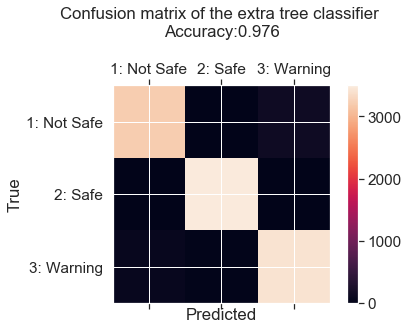

In [103]:
import seaborn as sn
labels=['1: Not Safe', '2: Safe', '3: Warning']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the extra tree classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, prediction_2)),y=1.2)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

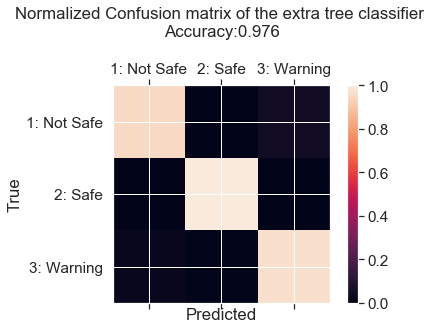

In [105]:
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels=['1: Not Safe', '2: Safe', '3: Warning']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(norm_cm)
plt.title('Normalized Confusion matrix of the extra tree classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, prediction_2)),y=1.2)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [106]:
from sklearn.metrics import hamming_loss
hamming_loss(y_test, prediction_2)

0.02357809642960254

Hamming_loss value is very low, which shows the better performance of the learning algorithm.

In [148]:
feature_importances=pipeline_2.steps[1][1].feature_importances_
viz=list(zip(X.columns, feature_importances))
print(viz)

[('MaximumCapacity', 0.00010761348261489092), ('ViolationRatePercent', 0.0014042855508064466), ('TotalEducationalWorkers', 5.011412309221521e-06), ('PublicHealthHazardViolationRate', 0.0008402926869307131), ('CriticalViolationRate', 0.00017738613921541705), ('time', 8.981633317969614e-05), ('RegulationSummary', 2.0288753190223194e-06), ('InspectionSummaryResult', 0.0002917593830964625), ('Borough', 1.7748047993655098e-05), ('FacilityType', 1.1952568199891351e-05)]
